<a href="https://colab.research.google.com/github/iakioh/MusiCAN/blob/main/models/first_music_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Settings

In [2]:
# Pianoroll parameters
notes_per_octave = 12
number_octaves = 6   # as in MuseGAN
number_pitches = number_octaves * notes_per_octave

number_bars = 1
beats_per_bar = 4   # 4/4 rythm
blips_per_beat = 24   # temporal resolution of Lakh dataset
number_blips  = number_bars * beats_per_bar * blips_per_beat

pianoroll_size = number_pitches * number_blips

print(f"pianoroll array: {number_pitches}x{number_blips} = {pianoroll_size}")


# Generator parameters
seed_length = 64


pianoroll array: 72x96 = 6912


## Data Preparation

## Model

In [3]:
# code from https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x

In [43]:
class Generator (torch.nn.Module) :
    """
    first GAN generator, MLP, layer size doubles until output size O is reached.

    input : normally distributed random vector of length I, seed vector
    output: binary vector of length O, pianoroll
    """


    def __init__ (self, log = False) : 
        super().__init__()
        
        I = seed_length   # length of input vector
        O = pianoroll_size    # length of output vector
        x = 4   # linear layer output_length/input_length ratio,
                # the higher x is, the fewer layers are needed to generate the 
                # output vector.

        layers = []
        current_size = I
        while x*current_size < O:
            layers.extend([
                torch.nn.Linear(current_size, x*current_size),
                torch.nn.BatchNorm1d(x*current_size),
                torch.nn.ReLU(),
            ])
            current_size *= x
        layers.extend([
            torch.nn.Linear(current_size, O),
            StraightThroughEstimator()
        ])

        self.generator = torch.nn.Sequential(*layers)

        if log :
            print(f"Generator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: {(len(layers)+1) // 3}")
            print("")


    def forward (self, seed) :
        pianoroll = self.generator(seed)

        return pianoroll

In [47]:
class Discriminator (torch.nn.Module) :
    """
    first GAN discriminator, basically Generator in reverse but 
    
    input : binary vector of length I, pianoroll
    output: single number, prob. that the input is a real and not 
            generated pianoroll
    """


    def __init__ (self, log = False) :
        super().__init__()

        I = pianoroll_size   # length of input vector
        O = 1   # length of output vector
        x = 4   # linear layer input_length/output_length ratio,
                # the higher x is, the fewer layers are needed to condense the 
                # input vector to a single number.

        layers = []
        layers.append(torch.nn.BatchNorm1d(I))
        current_size = I
        while current_size >= x**2*O :
            layers.extend([
                torch.nn.Linear(current_size, current_size//x),
                torch.nn.BatchNorm1d(current_size//x),
                torch.nn.ReLU(),
            ])
            current_size //= x
        layers.extend([
            torch.nn.Linear(current_size, O),
            torch.nn.Sigmoid(),
        ])

        self.discriminator = torch.nn.Sequential(*layers)

        if log :
            print(f"Discriminator:")
            print(f"    I: {I}, O: {O}")
            print(f"    layers: {len(layers) // 3}")
            print("")


    def forward (self, pianoroll):
        judgement = self.discriminator(pianoroll)
        return judgement

## Testing

Generator:
    I: 64, O: 6912
    layers: 4



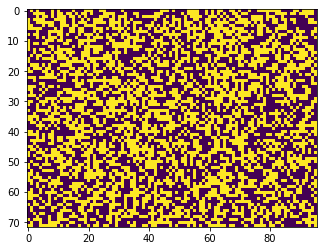

In [44]:
gen = Generator(log=True)

gen_out = gen.forward(torch.rand((5, seed_length)))
pr = gen_out.cpu().detach().numpy()
pr = pr.reshape((5, number_pitches, number_blips))

plt.imshow(pr[0]);

In [48]:
dis = Discriminator(log=True)

dis_out = dis.forward(gen_out)
judge = dis_out.cpu().detach().numpy().flatten()

print(f"Prob. that image is real: {judge[0]*100:.0f}%")


Discriminator:
    I: 6912, O: 1
    layers: 6

Prob. that image is real: 56%


## Junk & quick tests

In [10]:
# old Discriminator Code

'''
n = 1
while 2**(n+1) < I :
    n += 1
current_size = int(2**n)

while n > 1:
    layers.extend([
        torch.nn.BatchNorm1d(2**n),
        torch.nn.Linear(2**n, 2**(n-1)),
        torch.nn.ReLU(),
    ])
    current_size *= 2
''';

In [11]:
# old Generator code
'''
torch.nn.Linear(I, 2*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(2*I),
    torch.nn.Linear(2*I, 4*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(4*I),
    torch.nn.Linear(4*I, 8*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(8*I),
    torch.nn.Linear(8*I, 16*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(16*I),
    torch.nn.Linear(16*I, 32*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32*I),
    torch.nn.Linear(32*I, 64*I),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64*I),
    torch.nn.Linear(64*I, O),
    StraightThroughEstimator()
'''

'''
self.layer0 = torch.nn.Linear(I, 2*I)
self.layer1 = torch.nn.Linear(2*I, 4*I)
self.layer2 = torch.nn.Linear(4*I, 8*I)
self.layer3 = torch.nn.Linear(8*I, 16*I)
self.layer4 = torch.nn.Linear(16*I, 32*I)
self.layer5 = torch.nn.Linear(32*I, 64*I)
self.layer6 = torch.nn.Linear(64*I, O)

layer_input = torch.nn.functional.relu(self.layer0(input))
layer_input = torch.nn.functional.relu(self.layer1(input))
layer_input = torch.nn.functional.relu(self.layer2(input))
layer_input = torch.nn.functional.relu(self.layer3(input))
layer_input = torch.nn.functional.relu(self.layer4(input))
layer_input = torch.nn.functional.relu(self.layer5(input))
output = StraightThroughEstimator.forward(self.layer6(input))
''';

In [12]:
lll = [1, 3]
lll.extend([2, 4])
print(lll)

[1, 3, 2, 4]
